# **Volunteer Plant**

###I. Business understanding

**1. Business Objective**:   
identify volunteer plants and determine if they are helpful medicinal plants or harmful weeds.  
**2. Data Science Objective** :  
Automated Classification of Volunteer Plants

###II. Data aquisition and understanding

requirements

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
import shutil
import random
import numpy as np
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict

In [2]:
#modeling
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks

In [3]:
#loading
from tensorflow.keras.models import load_model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder_path = '/content/drive/MyDrive'

# Define common image extensions
image_extensions = ('.jpg')

# Loop through and remove only image files
for filename in os.listdir(folder_path):
    if filename.lower().endswith(image_extensions):
        file_path = os.path.join(folder_path, filename)
        os.remove(file_path)
        print(f"Removed: {file_path}")

#### 1. Data understanding

In [6]:
# Path to dataset in Google Drive
data= "/content/drive/MyDrive/volunteer plants/data/"
output_dir = "/content/drive/MyDrive/volunteer plants/data_prep/"

##### **files type**

In [ ]:
image_extensions = set()

# Supported image extensions
valid_exts = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}

for species_folder in os.listdir(data):
    species_path = os.path.join(data, species_folder)

    if os.path.isdir(species_path):
        for file in os.listdir(species_path):
            file_path = os.path.join(species_path, file)

            if os.path.isfile(file_path):
                ext = os.path.splitext(file)[1].lower()
                if ext in valid_exts:
                    image_extensions.add(ext)

print("Image file types found:", image_extensions)

Image file types found: {'.jpg'}


**=>** We have only jpg files

##### Data samples

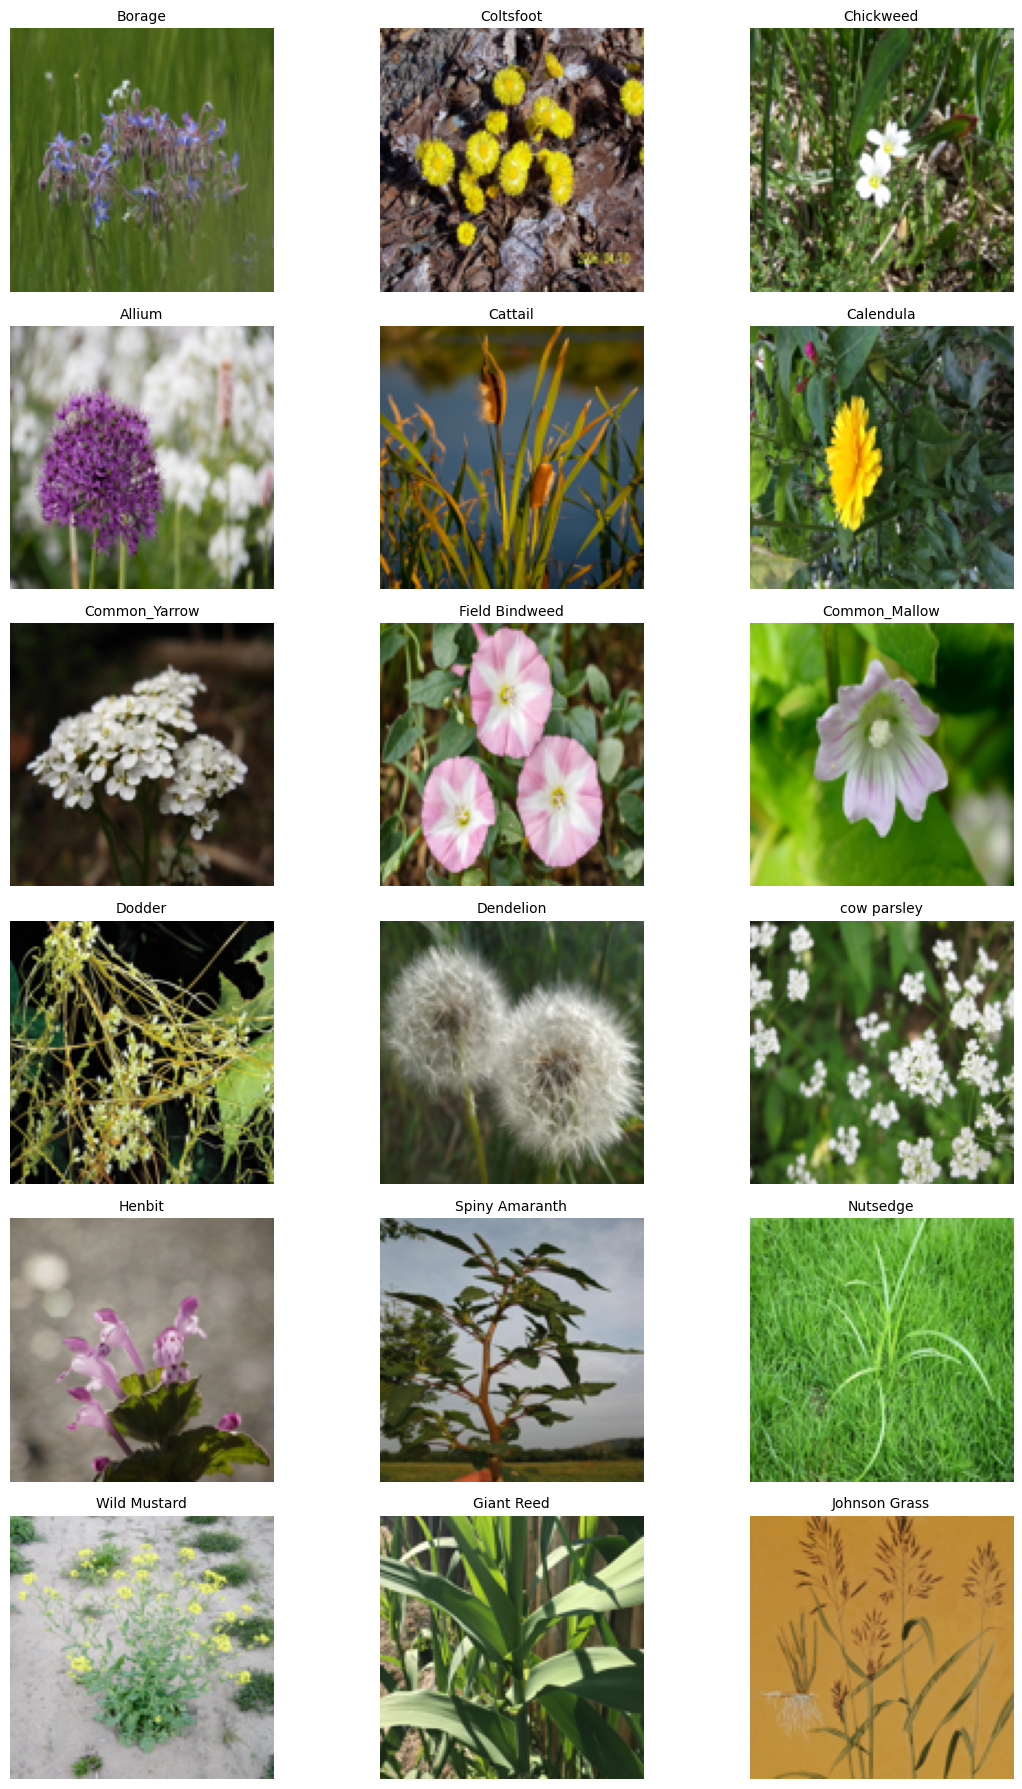

In [ ]:
n_samples = 1
cols = 3
class_folders = [f for f in os.listdir(data) if os.path.isdir(os.path.join(data, f))]
rows = math.ceil(len(class_folders) * n_samples / cols)

plt.figure(figsize=(12, 3 * rows))  # Adjust height based on rows

for i, class_name in enumerate(class_folders):
    class_path = os.path.join(data, class_name)
    images = os.listdir(class_path)[:n_samples]

    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        img = img.resize((120, 120))

        plt.subplot(rows, cols, i * n_samples + j + 1)
        plt.imshow(img)
        plt.title(class_name, fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()

#####**Data balancing verfication**

classes names

In [7]:
# Extract class names (folder names) and counts
class_names = []
class_counts = []

for class_folder in os.listdir(data):
    class_path = os.path.join(data, class_folder)
    if os.path.isdir(class_path):
        # Count files in the folder (assuming all are images)
        num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_names.append(class_folder)
        class_counts.append(num_files)
# Check for empty folders
if not class_names:
    print("No classes found! Check your folder structure.")

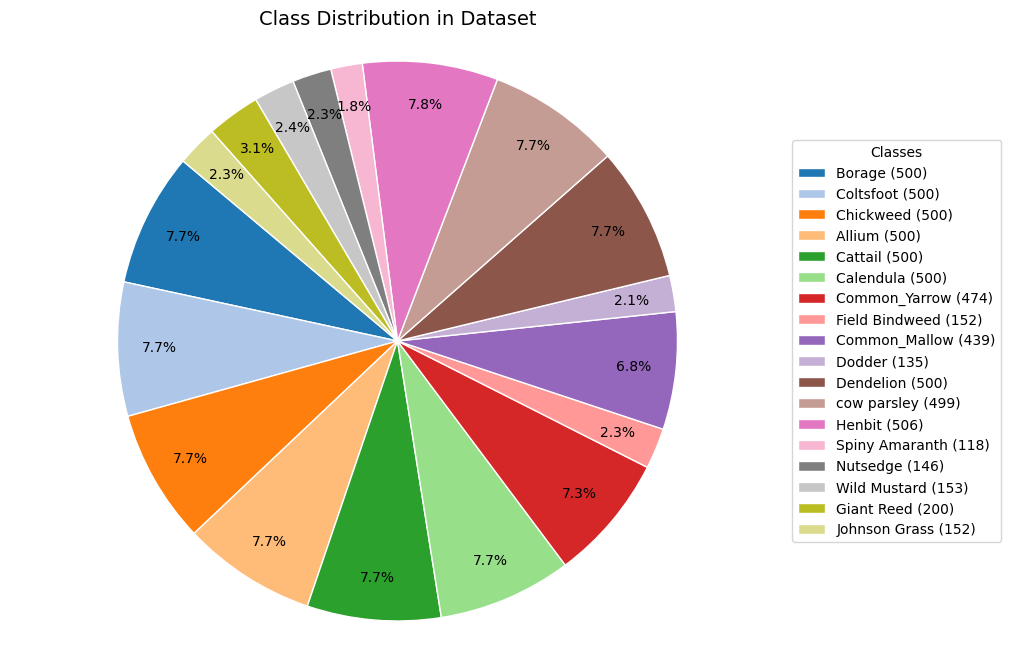

In [ ]:
# Plot settings
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20.colors

# Create pie chart
wedges, texts, autotexts = plt.pie(
    class_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Add legend with class names and counts
plt.legend(
    wedges,
    [f"{name} ({count})" for name, count in zip(class_names, class_counts)],
    title="Classes",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title("Class Distribution in Dataset", fontsize=14)
plt.axis('equal')
plt.show()

Classes détectées (18 classes) :
- Giant Reed
- Field Bindweed
- Nutsedge
- Spiny Amaranth
- Dodder
- Wild Mustard
- Henbit
- Dendelion
- Johnson Grass
- cow parsley
- Allium
- Calendula
- Common_Mallow
- Common_Yarrow
- Borage
- Cattail
- Coltsfoot
- Chickweed  


**=>** The class distribution here is noticeably imbalanced. A few classes like Calendula, Dendelion, Henbit, Coltsfoot, and Borage have close to or exactly 500+ samples, while others like Dodder (135), Spiny Amaranth (118), Nutsedge (146), and Johnson Grass (152) are significantly underrepresented.

####2. Data preparation

**Balancing data**

In [ ]:
# Create output_dir directory and copy original structure
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print("📁 Creating balanced data directory...")

    for class_name in class_names:
        orig_class_dir = os.path.join(data, class_name)
        new_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(new_class_dir, exist_ok=True)

        # Copy all original images
        for file_name in os.listdir(orig_class_dir):
            src = os.path.join(orig_class_dir, file_name)
            dst = os.path.join(new_class_dir, file_name)
            if os.path.isfile(src):
                shutil.copy2(src, dst)
    print("✅ All original data copied to output_dir/")

# Set up augmentation generator
aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

target_count = 500  # Desired number of images per class

# Perform augmentation on the copied dataset
for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    current_count = len(images)

    print(f"🔄 Augmenting class '{class_name}' ({current_count}/{target_count})...")

    if current_count < target_count:
        while len(os.listdir(class_dir)) < target_count:
            img_name = random.choice(images)
            img_path = os.path.join(class_dir, img_name)

            # Load and resize the image
            img = Image.open(img_path).resize((150, 150))

            # Ensure the image is in RGB format
            img = img.convert('RGB')

            # Convert to NumPy array with shape (1, 150, 150, 3)
            x = np.expand_dims(np.array(img), axis=0)

            # Generate and save a single new image
            for batch in aug.flow(x, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpg'):
                break

        print(f"✅ '{class_name}' balanced to {target_count} images.")

print("🎉 All classes have been balanced successfully in 'output_dir/'")

📁 Creating balanced data directory...
✅ All original data copied to output_dir/
🔄 Augmenting class 'Borage' (500/500)...
🔄 Augmenting class 'Coltsfoot' (500/500)...
🔄 Augmenting class 'Chickweed' (500/500)...
🔄 Augmenting class 'Allium' (500/500)...
🔄 Augmenting class 'Cattail' (500/500)...
🔄 Augmenting class 'Calendula' (500/500)...
🔄 Augmenting class 'Common_Yarrow' (474/500)...
✅ 'Common_Yarrow' balanced to 500 images.
🔄 Augmenting class 'Field Bindweed' (152/500)...
✅ 'Field Bindweed' balanced to 500 images.
🔄 Augmenting class 'Common_Mallow' (439/500)...
✅ 'Common_Mallow' balanced to 500 images.
🔄 Augmenting class 'Dodder' (135/500)...
✅ 'Dodder' balanced to 500 images.
🔄 Augmenting class 'Dendelion' (500/500)...
🔄 Augmenting class 'cow parsley' (499/500)...
✅ 'cow parsley' balanced to 500 images.
🔄 Augmenting class 'Henbit' (506/500)...
🔄 Augmenting class 'Spiny Amaranth' (118/500)...
✅ 'Spiny Amaranth' balanced to 500 images.
🔄 Augmenting class 'Nutsedge' (146/500)...
✅ 'Nutsedg

**Splitting data**

In [ ]:
# Source (balanced) and destination root directory
source_dir = output_dir
split_dir = "/content/drive/MyDrive/volunteer plants/split_data/"

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure destination folders exist
for split in ['train', 'val', 'test']:
    for class_name in class_names:
        split_class_dir = os.path.join(split_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

print("📁 Creating train/val/test structure...")

# For each class, shuffle and split
for class_name in class_names:
    class_path = os.path.join(source_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split, split_images in splits.items():
        for img_name in split_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(split_dir, split, class_name, img_name)
            shutil.copy2(src, dst)

    print(f"✅ Split '{class_name}': {len(splits['train'])} train, {len(splits['val'])} val, {len(splits['test'])} test")

print("🎉 Dataset split complete and saved in 'split_data/'")

📁 Creating train/val/test structure...
✅ Split 'Borage': 350 train, 75 val, 75 test
✅ Split 'Coltsfoot': 350 train, 75 val, 75 test
✅ Split 'Chickweed': 350 train, 75 val, 75 test
✅ Split 'Allium': 350 train, 75 val, 75 test
✅ Split 'Cattail': 350 train, 75 val, 75 test
✅ Split 'Calendula': 350 train, 75 val, 75 test
✅ Split 'Common_Yarrow': 350 train, 75 val, 75 test
✅ Split 'Field Bindweed': 350 train, 75 val, 75 test
✅ Split 'Common_Mallow': 350 train, 75 val, 75 test
✅ Split 'Dodder': 350 train, 75 val, 75 test
✅ Split 'Dendelion': 350 train, 75 val, 75 test
✅ Split 'cow parsley': 350 train, 75 val, 75 test
✅ Split 'Henbit': 354 train, 75 val, 77 test
✅ Split 'Spiny Amaranth': 350 train, 75 val, 75 test
✅ Split 'Nutsedge': 350 train, 75 val, 75 test
✅ Split 'Wild Mustard': 350 train, 75 val, 75 test
✅ Split 'Giant Reed': 350 train, 75 val, 75 test
✅ Split 'Johnson Grass': 350 train, 75 val, 75 test
🎉 Dataset split complete and saved in 'split_data/'


In [ ]:
splits = ['train', 'val', 'test']

# Dictionary to store counts
class_counts = defaultdict(lambda: defaultdict(int))

for split in splits:
    split_path = os.path.join(split_dir, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            count = len([
                fname for fname in os.listdir(class_dir)
                if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[split][class_name] = count

# Print the results
for split in splits:
    print(f"\n📁 {split.upper()}:")
    for class_name, count in class_counts[split].items():
        print(f"  {class_name}: {count} images")


📁 TRAIN:
  Borage: 350 images
  Coltsfoot: 350 images
  Chickweed: 350 images
  Allium: 350 images
  Cattail: 350 images
  Calendula: 350 images
  Common_Yarrow: 350 images
  Field Bindweed: 350 images
  Common_Mallow: 350 images
  Dodder: 350 images
  Dendelion: 350 images
  cow parsley: 350 images
  Henbit: 354 images
  Spiny Amaranth: 350 images
  Nutsedge: 350 images
  Wild Mustard: 350 images
  Giant Reed: 350 images
  Johnson Grass: 350 images

📁 VAL:
  Borage: 75 images
  Coltsfoot: 75 images
  Chickweed: 75 images
  Allium: 75 images
  Cattail: 75 images
  Calendula: 75 images
  Common_Yarrow: 75 images
  Field Bindweed: 75 images
  Common_Mallow: 75 images
  Dodder: 75 images
  Dendelion: 75 images
  cow parsley: 75 images
  Henbit: 75 images
  Spiny Amaranth: 75 images
  Nutsedge: 75 images
  Wild Mustard: 75 images
  Giant Reed: 75 images
  Johnson Grass: 75 images

📁 TEST:
  Borage: 75 images
  Coltsfoot: 75 images
  Chickweed: 75 images
  Allium: 75 images
  Cattail: 75 i

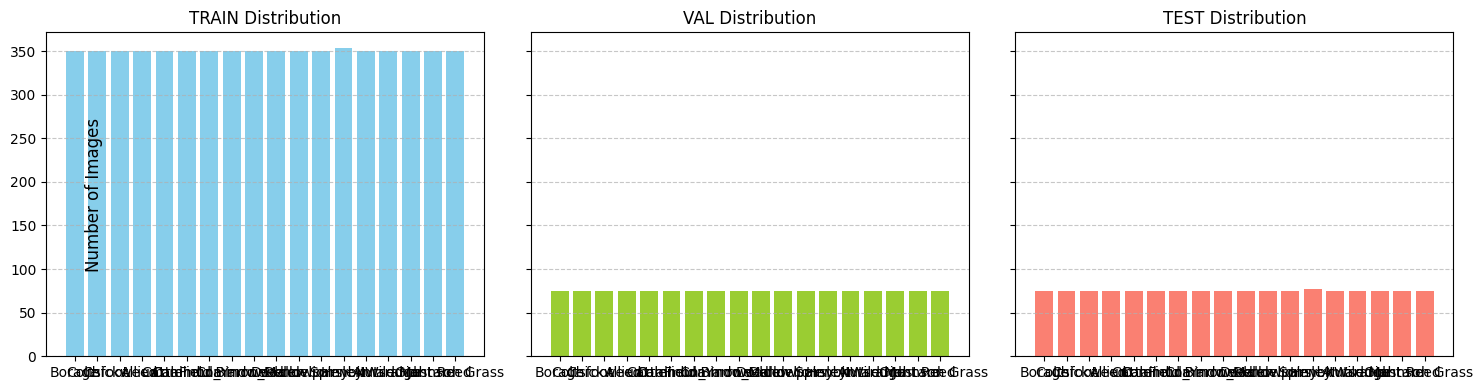

In [ ]:
split_colors = {'train': 'skyblue', 'val': 'yellowgreen', 'test': 'salmon'}
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for i, split in enumerate(splits):
    classes = list(class_counts[split].keys())
    counts = list(class_counts[split].values())
    color = split_colors[split]
    axs[i].bar(classes, counts, color=color)
    axs[i].set_title(f"{split.upper()} Distribution")
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

fig.text(0.06, 0.5, 'Number of Images', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image

def calculate_ssim(img1, img2):
    # Convert to grayscale and ensure same size
    img1_gray = img1.convert('L')
    img2_gray = img2.convert('L')

    # Resize images to the same dimensions (using the first image's size)
    if img1_gray.size != img2_gray.size:
        img2_gray = img2_gray.resize(img1_gray.size, Image.BILINEAR)

    img1_array = np.array(img1_gray)
    img2_array = np.array(img2_gray)

    score, _ = ssim(img1_array, img2_array, full=True)
    return score

# Load images
original_img = Image.open("/content/drive/MyDrive/volunteer plants/data_prep/Nutsedge/Nutsedge_045.jpg")
augmented_img = Image.open("/content/drive/MyDrive/volunteer plants/data_prep/Nutsedge/aug_0_425.jpg")

# Calculate SSIM
ssim_score = calculate_ssim(original_img, augmented_img)
print(f"SSIM Score: {ssim_score:.4f}")

SSIM Score: 0.7761


### Modeling

#### Preprocess Data for Model Input

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/volunteer plants/split_data/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/volunteer plants/split_data/val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)


Found 6304 images belonging to 18 classes.
Found 1350 images belonging to 18 classes.


#### Building the Xception Model

In [ ]:
# Load the Xception model without the top layer (we'll add our own)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers to avoid re-training them
for layer in base_model.layers:
    layer.trainable = False

# Build the model on top of Xception
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Dense(1024, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(len(class_names), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Model training

In [ ]:
  # Set up callbacks for early stopping and saving the best model
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_xception_model.weights.h5', save_best_only=True, save_weights_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 2646s 13s/step - accuracy: 0.3458 - loss: 2.2829 - val_accuracy: 0.7143 - val_loss: 1.0833
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 192s 970ms/step - accuracy: 0.6583 - loss: 1.1232 - val_accuracy: 0.7671 - val_loss: 0.7949
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 204s 985ms/step - accuracy: 0.7311 - loss: 0.8921 - val_accuracy: 0.7894 - val_loss: 0.6943
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 201s 980ms/step - accuracy: 0.7544 - loss: 0.7855 - val_accuracy: 0.7932 - val_loss: 0.6473
Epoch 5/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 202s 979ms/step - accuracy: 0.7789 - loss: 0.7113 - val_accuracy: 0.8207 - val_loss: 0.5893
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 195s 988ms/step - accuracy: 0.7829 - loss: 0.6712 - val_accuracy: 0.8274 - val_loss: 0.5649
Epoch 7/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 202s 990ms/step - accuracy: 0.7991 - loss: 0.6248 - val_accuracy: 0.8348 - val_loss: 0.5442
Epoch 8/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 202s 989ms/step - accuracy: 0.8112 - 

In [8]:
save_path= "/content/drive/MyDrive/volunteer plants/models/xception_model.keras"
model.save(save_path)
print(f"✅ Model saved to: {save_path}")

NameError: name 'model' is not defined

In [8]:
model = load_model('/content/drive/MyDrive/volunteer plants/models/xception_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_xception_model_resume.weights.h5', save_best_only=True, save_weights_only=True)

# Resume training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    initial_epoch=30,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 31/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2439s 12s/step - accuracy: 0.7627 - loss: 0.7326 - val_accuracy: 0.8088 - val_loss: 0.5706
Epoch 32/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 238s 972ms/step - accuracy: 0.7945 - loss: 0.6275 - val_accuracy: 0.8095 - val_loss: 0.5591
Epoch 33/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 194s 984ms/step - accuracy: 0.8098 - loss: 0.5810 - val_accuracy: 0.8251 - val_loss: 0.5123
Epoch 34/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 193s 977ms/step - accuracy: 0.8199 - loss: 0.5578 - val_accuracy: 0.8415 - val_loss: 0.5289
Epoch 35/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 201s 974ms/step - accuracy: 0.8173 - loss: 0.5378 - val_accuracy: 0.8378 - val_loss: 0.5467
Epoch 36/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 203s 978ms/step - accuracy: 0.8281 - loss: 0.5235 - val_accuracy: 0.8757 - val_loss: 0.4046
Epoch 37/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 200s 972ms/step - accuracy: 0.8241 - loss: 0.5207 - val_accuracy: 0.8728 - val_loss: 0.4314
Epoch 38/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 203s 980ms/step - accuracy: 0

In [11]:
save_path= "/content/drive/MyDrive/volunteer plants/models/xception_model_50.keras"
model.save(save_path)
print(f"✅ Model saved to: {save_path}")

✅ Model saved to: /content/drive/MyDrive/volunteer plants/models/xception_model_50.keras


In [6]:
model = load_model('/content/drive/MyDrive/volunteer plants/models/xception_model_50.keras')

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/volunteer plants/split_data/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 1352 images belonging to 18 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 543s 13s/step - accuracy: 0.8790 - loss: 0.3902
Test Loss: 0.4399
Test Accuracy: 0.8580


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step
Classification Report:
                precision    recall  f1-score   support

        Allium       0.92      0.80      0.86        75
        Borage       0.93      0.85      0.89        75
     Calendula       0.94      0.97      0.95        75
       Cattail       0.89      0.93      0.91        75
     Chickweed       0.85      0.97      0.91        75
     Coltsfoot       0.95      0.97      0.96        75
 Common_Mallow       0.89      0.88      0.89        75
 Common_Yarrow       0.85      0.95      0.89        75
     Dendelion       0.95      0.93      0.94        75
        Dodder       0.76      0.84      0.80        75
Field Bindweed       0.95      0.81      0.88        75
    Giant Reed       0.75      0.79      0.77        75
        Henbit       0.82      0.92      0.87        77
 Johnson Grass       0.79      0.59      0.67        75
      Nutsedge       0.74      0.87      0.80        75
Spiny Amaranth       0.82      0.68   

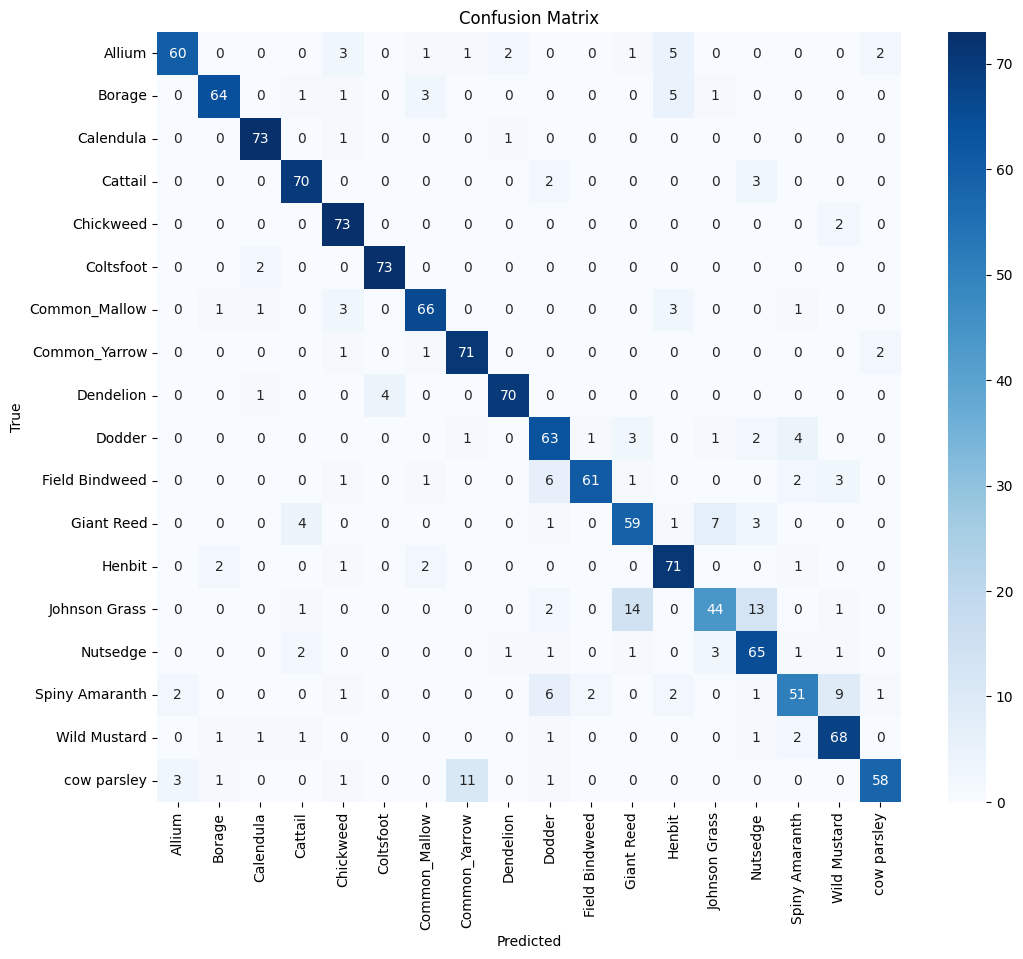

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
